# Read data

In [2]:
import pandas as pd
import numpy as np

In [3]:
# read data with the number of train rides and the minutes of delay
data_rides = pd.read_csv("../dat/Zugfahrten_2016_12.csv", sep = ";", encoding = "latin-1")

# rename columns (english translation)
data_rides.columns = ["Station or stop", "Country", "Date", "Number of train rides", "Minutes of delay"]

In [4]:
# read data with the coordinates of the stations
data_stations = pd.read_csv("../dat/GEO_Bahnstellen_EXPORT.csv", sep = ";", encoding = "latin-1")

# rename columns (english translation)
data_stations.columns = ["Station or stop", "Name", "Country", "Coordinate Latitude", "Coordinate Longitude"]

In [5]:
# merge the two dataframes
data = pd.merge(data_rides, data_stations, on = "Station or stop")
data = data.drop(["Country_x"], axis = 1)

# rename the column "Country_y" to "Country"
data = data.rename(columns = {"Country_y": "Country"})
len(data)

766028

# Take a look...

In [6]:
data.head()

,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude
0,80197079,16.03.2016 00:00,39,49,KINDSBACH,DEUTSCHLAND,49.420450,7.613668
1,80160168,01.11.2016 00:00,12,0,NIEDERTREBRA,DEUTSCHLAND,51.065500,11.580700
2,80105122,30.04.2016 00:00,16,2,HAMM FELDMARK,DEUTSCHLAND,51.697611,7.787870
3,80190793,31.07.2016 00:00,14,0,LUDWIGSHAFEN (RHEIN) BASF,DEUTSCHLAND,49.510682,8.428922
4,80231464,04.05.2016 00:00,10,2,BURGKEMNITZ,DEUTSCHLAND,51.689400,12.407990


<Axes: >

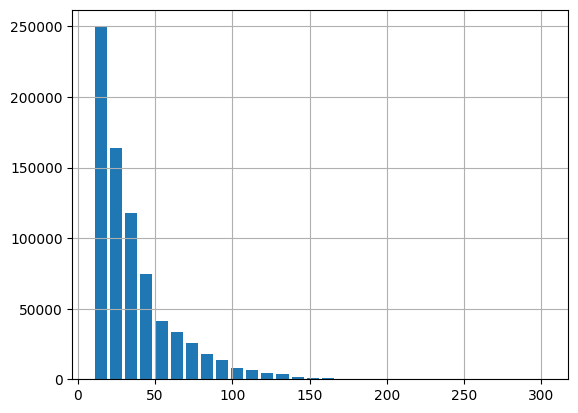

In [7]:
# histogram of the number of train rides
data["Number of train rides"].hist(bins = 30, rwidth = 0.8)

<Axes: >

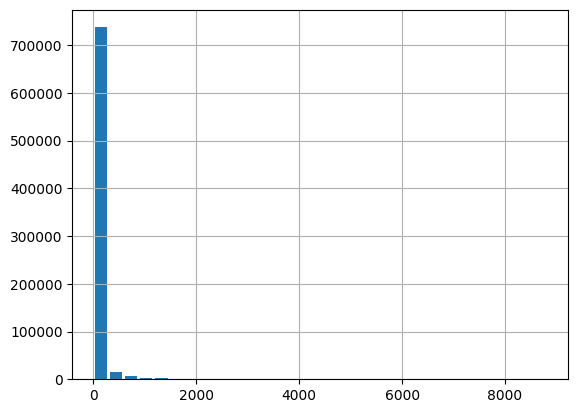

In [8]:
# histogram of the minutes of delay
data["Minutes of delay"].hist(bins = 30, rwidth = 0.8)

<Axes: xlabel='Country'>

/Users/frederikpanse/Desktop/db_project/venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 132 (\x84) missing from current font.
  func(*args, **kwargs)
/Users/frederikpanse/Desktop/db_project/venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 150 (\x96) missing from current font.
  func(*args, **kwargs)
/Users/frederikpanse/Desktop/db_project/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/frederikpanse/Desktop/db_project/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


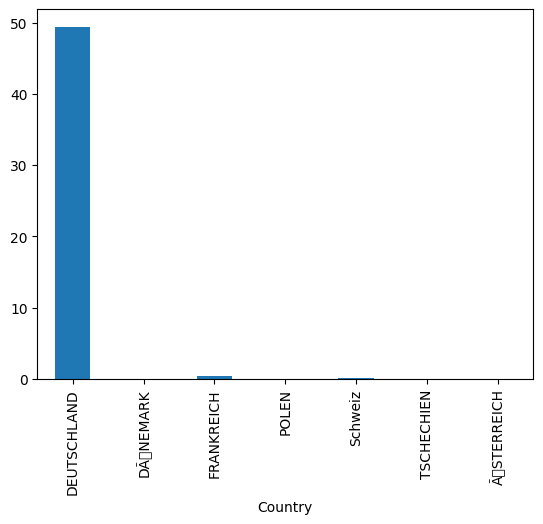

In [9]:
# histogram of the minutes of delay per country
data.groupby("Country")["Minutes of delay"].mean().plot(kind = "bar")

# Data cleaning

In [10]:
# 1) Include only values for Germany
data = data[data['Country'] == "DEUTSCHLAND"]

# check if it worked
print(len(data))
print(data['Country'].unique())

757228
['DEUTSCHLAND']


In [11]:
# 2) Missing values

# check for missing values
data.isnull().sum()

# drop rows with missing values
data = data.dropna(axis = 0, how = "any")

# check if it worked
print(len(data))
data.isnull().sum()

757007


Station or stop          0
Date                     0
Number of train rides    0
Minutes of delay         0
Name                     0
Country                  0
Coordinate Latitude      0
Coordinate Longitude     0
dtype: int64

In [12]:
# 3) Calculate mean for every station

# drop columns that are not needed
data_mean = data.drop(columns = ["Date", "Country", "Coordinate Latitude", "Coordinate Longitude", "Name"])
data_mean = data_mean.groupby(["Station or stop"]).mean()

# get the names of the stations
data_names = data.drop(columns = ["Date", "Country", "Number of train rides", "Minutes of delay"])
data_names = data_names.drop_duplicates()

# merge the two dataframes
data_mean = pd.merge(data_names, data_mean, on = "Station or stop", how = "left")

In [13]:
# check if it worked
data_mean

,Station or stop,Name,Coordinate Latitude,Coordinate Longitude,Number of train rides,Minutes of delay
0,80197079,KINDSBACH,49.420450,7.613668,30.880503,54.720126
1,80160168,NIEDERTREBRA,51.065500,11.580700,28.091228,0.691228
2,80105122,HAMM FELDMARK,51.697611,7.787870,23.058594,33.949219
3,80190793,LUDWIGSHAFEN (RHEIN) BASF,49.510682,8.428922,27.984375,0.475000
4,80231464,BURGKEMNITZ,51.689400,12.407990,12.372549,1.176471
...,...,...,...,...,...,...
3107,80101972,DORTMUND BUSCHSTRASSE,51.538476,7.395210,12.000000,0.000000
3108,80264408,SCHWAIGEN,48.665453,12.598961,10.000000,14.000000
3109,80233973,HOHENRODA,51.499080,12.421535,10.000000,0.000000
3110,80060517,DRESDEN-DOBRITZ,51.013900,13.808676,14.000000,2.000000


In [14]:
# check if it worked
print(len(data_mean))

print(len(data_mean["Name"].unique()))

print(len(data_mean["Station or stop"].unique()))

3112
3105
3112


In [15]:
# 4) drop stations with less than 10 train rides in mean
data_mean = data_mean[data_mean["Number of train rides"] >= 10]

### Function to return data

In [16]:
def get_data(which = "full"):
    if which == "full":
        return data
    elif which == "mean":
        return data_mean
    else:
        print("Choose full or mean dataset.")

### Get which station is connected to which path

In [17]:
paths = pd.read_csv("../dat/path_delays.csv")

In [18]:
paths

,Path,Total Delay
0,4801 -> 4800 -> 4080 -> 3522 -> 3520,26.980872
1,4801 -> 4800 -> 4080 -> 3522 -> 3603,27.188116
2,4801 -> 4800 -> 4080 -> 4011 -> 4010,21.579940
3,4801 -> 4800 -> 4080 -> 4004 -> 4010,21.579940
4,4801 -> 4900 -> 4124 -> 5220 -> 3660,25.315917
...,...,...
103,4801 -> 4811 -> 4080 -> 4004 -> 4010,14.785629
104,4801 -> 4812 -> 4080 -> 3522 -> 3520,20.186561
105,4801 -> 4812 -> 4080 -> 3522 -> 3603,20.393805
106,4801 -> 4812 -> 4080 -> 4011 -> 4010,14.785629


In [19]:
stations = pd.read_csv("../dat/stations_with_nearest_routes.csv")
stations = stations.rename(columns = {"Station or stop": "Station"})

In [22]:
paths_dict = {}

# Iterate over rows and extract routes
for index, row in paths.iterrows():
    path_key = f"path{index}"
    routes = list(map(int, row["Path"].split(" -> ")))
    stations_for_routes = stations[stations.Route.isin(routes)].Station.to_list()
    values = {}
    values["routes"] = routes
    values["stations"] = stations_for_routes
    paths_dict[path_key] = values

for k, v in paths_dict.items():
    means = data_mean[data_mean["Station or stop"].isin(v["stations"])]["Minutes of delay"].mean()
    v["mean_delay"] = means

# Only retain stations that do not use the same stations
unique_stations = {}
for key, value in paths_dict.items():
    stations_key = tuple(value['stations'])
    if stations_key not in unique_stations:
        unique_stations[stations_key] = value

# If you want to convert it back to a dictionary
paths_dict = {f'path{i}': value for i, (key, value) in enumerate(unique_stations.items())}

In [24]:
def get_paths():
    return paths_dict

In [25]:
# save dictionary as numpy file
np.save('../dat/paths.npy', paths_dict)

Read the `paths.npy` file in the following way:
```{python}
paths = np.load('paths.npy', allow_pickle='TRUE').item()
```